Pokémon and Pokémon character names are trademarks of Nintendo.

In [1]:
import requests as rq
import json
import pandas as pd
from time import sleep
from sklearn.preprocessing import MultiLabelBinarizer
from bs4 import BeautifulSoup
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Getting data from PokéAPI

In [2]:
def find_usum_moves(js):
    usum_moves = []
    for move in js['moves']:
        in_usum = False
        for version_group in move['version_group_details']:
            if version_group['version_group']['name'] == 'ultra-sun-ultra-moon':
                in_usum = True
                break
        if in_usum:
            usum_moves.append(move['move']['name'])
    return usum_moves

def find_abilities(js):
    return [ability['ability']['name'] for ability in js['abilities']]

def find_types(js):
    return [typ['type']['name'] for typ in js['types']]

def find_eggs(js):
    return [egg['name'] for egg in js['egg_groups']]

In [3]:
#poke_dict = {}
#i = 1
#while True:
#    sleep(1)
#    url = 'https://pokeapi.co/api/v2/pokemon/' + str(i)
#    request = rq.get(url)
#    if request.status_code != 200:
#        break
#    js = json.loads(request.text)
#    tmp = {}
#    tmp[i] = {}
#    tmp[i]['name'] = js['name']
#    tmp[i]['moves'] = find_usum_moves(js)
#    tmp[i]['abilities'] = find_abilities(js)
#    tmp[i]['types'] = find_types(js)
#    species_url = js['species']['url']
#    sleep(1)
#    request = rq.get(species_url)
#    js = json.loads(request.text)
#    tmp[i]['egg_groups'] = find_eggs(js)
#    tmp[i]['generation'] = js['generation']['name']
#    poke_dict.update(tmp)
#    i += 1
#df = pd.DataFrame(poke_dict).T
#df.to_pickle('pokemon_df.pkl')

In [4]:
# load the scraped data
# add name_ column to bypass the different forms, etc
df = pd.read_pickle('pokemon_df.pkl')
df['name_'] = df['name'].apply(lambda x: x.split('-')[0])

# Getting the Galar Pokédex from Bulbapedia

In [5]:
# get the pokemon list for Galar Pokedex
request = rq.get('https://bulbapedia.bulbagarden.net/wiki/List_of_Pok%C3%A9mon_by_Galar_Pok%C3%A9dex_number')
soup = BeautifulSoup(request.text)
# extracting relevant tables
tables = soup.find_all('table')[1:9]

In [6]:
sleep(4)
# get the list of pokemon newly added to gen 8 and all types
request = rq.get('https://bulbapedia.bulbagarden.net/wiki/Category:Generation_VIII_Pok%C3%A9mon')
soup = BeautifulSoup(request.text)
gen8_lst = [p.text.split(' (P')[0].lower() for p in soup.find_all('a')[13:98]]

type_lst = ['bug', 'dark', 'dragon', 'electric', 'fairy', 'fighting', 
            'fire', 'flying', 'ghost', 'grass', 'ground', 'ice', 
            'normal', 'poison', 'psychic', 'rock', 'steel', 'water']

In [7]:
# get the set of all pokemon in Galar Pokedex except those newly added in Gen 8
# split by ('-') to match the name_ column
poke_set = set()
for table in tables:
    for a in table.find_all('a'):
        txt = a.text.lower()
        if txt and txt not in type_lst and txt not in gen8_lst:
            # check if something crazy happens
            if '-' in txt:
                print(txt)
            poke_set.add(txt.split('-')[0])

jangmo-o
hakamo-o
kommo-o


# Adding Galar Pokédex information to the DataFrame

In [8]:
# make the survived column
for idx in df.index:
    if df.loc[idx, 'name_'] in poke_set:
        df.loc[idx, 'galar'] = True
    else:
        df.loc[idx, 'galar'] = False

In [9]:
# check for exceptions
for p in poke_set:
    if p not in df['name_'].unique():
        print(p)

mr. mime
mime jr.
type: null
farfetch'd


In [10]:
# correct for the exception cases
df.loc[122, 'galar'] = True # 'mr-mime'
df.loc[772, 'galar'] = True # 'type-null'
df.loc[439, 'galar'] = True # 'mime-jr'
df.loc[83, 'galar'] = True # 'farfetchd'

# Making DataFrames with Dummy Variables

In [11]:
mlb = MultiLabelBinarizer()
egg_df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df['egg_groups']), columns=mlb.classes_, index=df.index)], axis=1)
all_df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df['egg_groups']), columns=mlb.classes_, index=df.index)], axis=1)

mlb = MultiLabelBinarizer()
abil_df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df['abilities']), columns=mlb.classes_, index=df.index)], axis=1)
all_df = pd.concat([all_df, pd.DataFrame(mlb.fit_transform(df['abilities']), columns=mlb.classes_, index=df.index)], axis=1)

gen_df = pd.concat([df, pd.get_dummies(df['generation'])], axis=1)
all_df = pd.concat([all_df, pd.get_dummies(df['generation'])], axis=1)

mlb = MultiLabelBinarizer()
move_df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df['moves']), columns=mlb.classes_, index=df.index)], axis=1)
all_df = pd.concat([all_df, pd.DataFrame(mlb.fit_transform(df['moves']), columns=mlb.classes_, index=df.index)], axis=1)

mlb = MultiLabelBinarizer()
type_df = pd.concat([df, pd.DataFrame(mlb.fit_transform(df['types']), columns=mlb.classes_, index=df.index)], axis=1)
all_df = pd.concat([all_df, pd.DataFrame(mlb.fit_transform(df['types']), columns=mlb.classes_, index=df.index)], axis=1)

# Plotting Trees

In [12]:
# drop unnecessary columns for plotting trees
egg_df.drop(columns=['name', 'moves', 'abilities', 'types', 'generation', 'egg_groups', 'name_'], inplace=True)
abil_df.drop(columns=['name', 'moves', 'abilities', 'types', 'generation', 'egg_groups', 'name_'], inplace=True)
gen_df.drop(columns=['name', 'moves', 'abilities', 'types', 'generation', 'egg_groups', 'name_'], inplace=True)
move_df.drop(columns=['name', 'moves', 'abilities', 'types', 'generation', 'egg_groups', 'name_'], inplace=True)
type_df.drop(columns=['name', 'moves', 'abilities', 'types', 'generation', 'egg_groups', 'name_'], inplace=True)
all_df.drop(columns=['name', 'moves', 'abilities', 'types', 'generation', 'egg_groups', 'name_'], inplace=True)

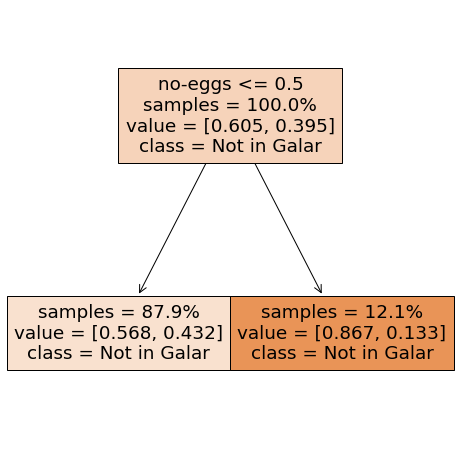

In [13]:
# egg group tree
X = egg_df.drop(columns=['galar'])
y = egg_df['galar'].astype('bool')
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(figsize=(8, 8))
plot_tree(clf, ax=ax, feature_names=X.columns, filled=True,
          class_names=['Not in Galar', 'In Galar'],
          impurity=False, proportion=True);

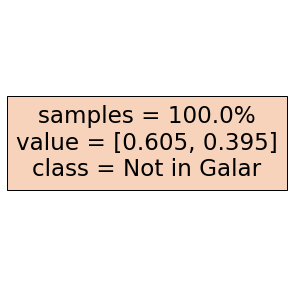

In [14]:
# ability tree
X = abil_df.drop(columns=['galar'])
y = abil_df['galar'].astype('bool')
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(figsize=(5, 5))
plot_tree(clf, ax=ax, feature_names=X.columns, filled=True,
          class_names=['Not in Galar', 'In Galar'],
          impurity=False, proportion=True);

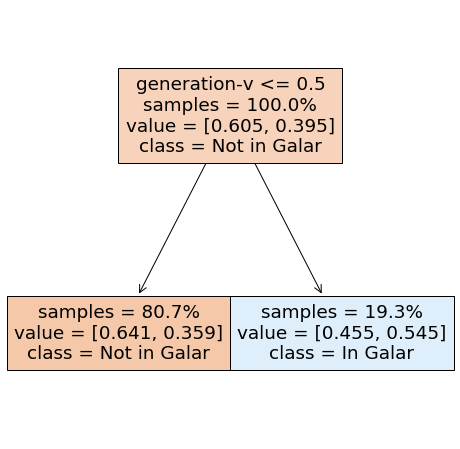

In [15]:
# generation tree
X = gen_df.drop(columns=['galar'])
y = gen_df['galar'].astype('bool')
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(figsize=(8, 8))
plot_tree(clf, ax=ax, feature_names=X.columns, filled=True,
          class_names=['Not in Galar', 'In Galar'],
          impurity=False, proportion=True);

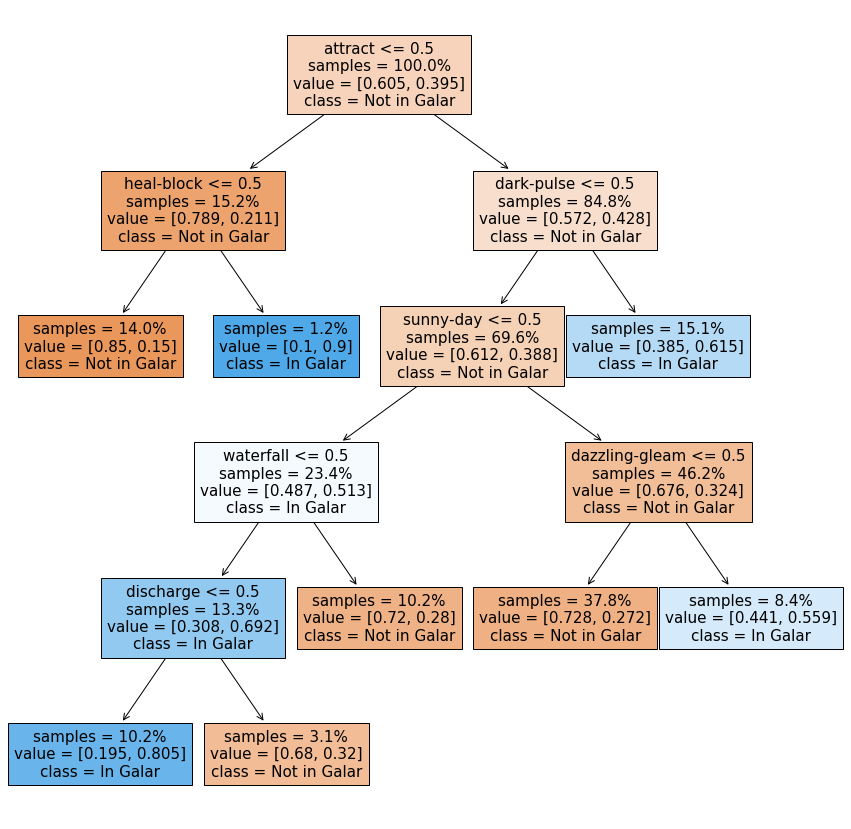

In [16]:
# moveset tree
X = move_df.drop(columns=['galar'])
y = move_df['galar'].astype('bool')
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(figsize=(15,15))
plot_tree(clf, ax=ax, feature_names=X.columns, filled=True,
          class_names=['Not in Galar', 'In Galar'],
          impurity=False, proportion=True);

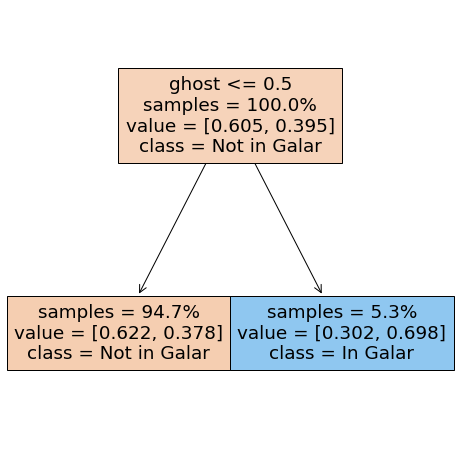

In [17]:
# type tree
X = type_df.drop(columns=['galar'])
y = type_df['galar'].astype('bool')
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(figsize=(8, 8))
plot_tree(clf, ax=ax, feature_names=X.columns, filled=True,
          class_names=['Not in Galar', 'In Galar'],
          impurity=False, proportion=True);

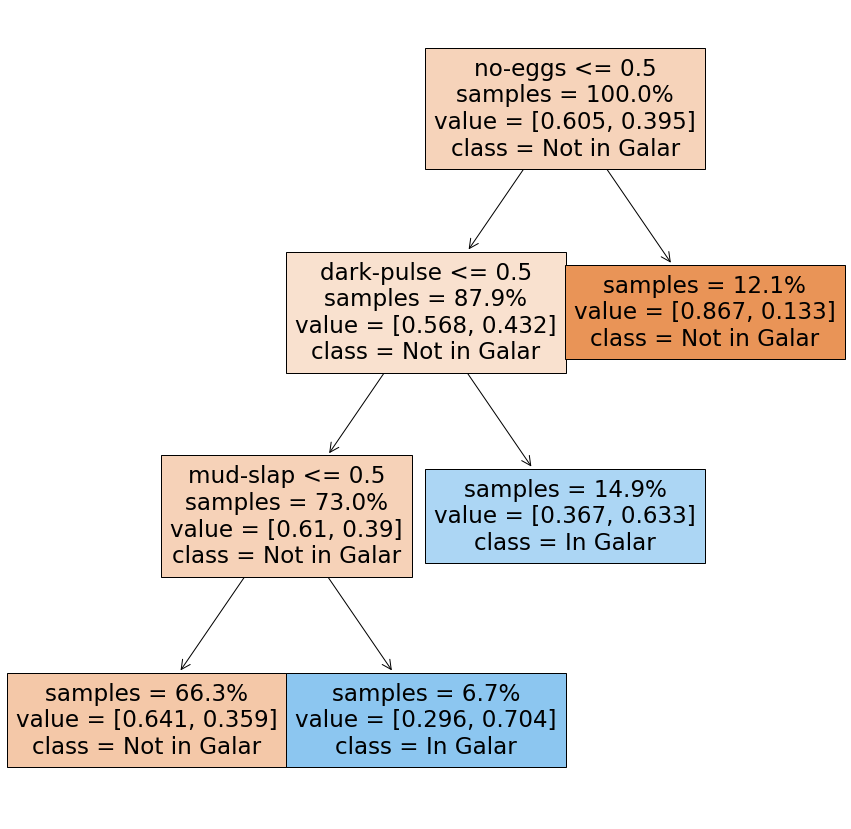

In [18]:
# tree using all variable
X = all_df.drop(columns=['galar'])
y = all_df['galar'].astype('bool')
clf = DecisionTreeClassifier(random_state=0, ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(figsize=(15, 15))
plot_tree(clf, ax=ax, feature_names=X.columns, filled=True,
          class_names=['Not in Galar', 'In Galar'],
          impurity=False, proportion=True);